In [260]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [261]:
from fastai.basics import *

import jkbc.utils.general as g
import jkbc.utils.files as f
import jkbc.utils.metrics as metric
import jkbc.utils.postprocessing as pop
import jkbc.utils.preprocessing as prep

## Constants

### Data

In [186]:
BLANK_ID       = pop.BLANK_ID
ALPHABET       = pop.ALPHABET # {0: '-', 1: 'A', 2: 'B'}
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET_VAL)
WINDOW_SIZE    = 300
STRIDE         = 300
DIMENSIONS_OUT = 70

BASE_DIR = Path("../..")
PATH_DATA = 'data/feather-files'
DATA_SET = f'Range0-50-FixLabelLen{DIMENSIONS_OUT}'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

### Train/Predict

In [187]:
LR = 1e-3  # default learning rate
BS = 1024  # batch size
EPOCHS_BEFORE_SAVING = 3
SAVE_MODEL_ITERATIONS = 3
DEVICE = torch.device("cuda:0") #torch.device("cpu")
MODEL_NAME = g.get_notebook_name()
MODEL_DIR = BASE_DIR/'models'/MODEL_NAME
SPECIFIC_MODEL = None #Set to specific name of model ('None' uses the newest)

### Model

In [188]:
DIMENSIONS_PREDICTION_OUT = 100
DROP_LAST    = True # SET TO TRUE IF IT FAILS ON LAST BATCH
LOSS_FUNC = metric.ctc_loss(DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)
METRICS = [metric.ErrorRate(metric.ctc_error(ALPHABET, 5))]

## Load data

In [189]:
# Read data from feather
data = f.read_data_from_feather_file(FEATHER_FOLDER)

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
del data
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)
del train_dl
del valid_dl

## Model

## Build
*Put entire model definition and constants in the same field*

In [190]:
activations = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
}


class Model(nn.Module):
    """
    Model template for QuartzNet style architectures

    https://arxiv.org/pdf/1910.10261.pdf
    """
    def __init__(self, config):
        super(Model, self).__init__()
        self.stride = config['block'][0]['stride'][0]
        self.alphabet = config['labels']['labels']
        self.features = config['block'][-1]['filters']
        self.encoder = Encoder(config)
        self.decoder = Decoder(self.features, len(self.alphabet))

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)


class Encoder(nn.Module):
    """
    Builds the model encoder
    """
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config

        features = self.config['input']['features']
        activation = activations[self.config['encoder']['activation']]()
        encoder_layers = []

        for layer in self.config['block']:
            encoder_layers.append(
                Block(
                    features, layer['filters'], activation,
                    repeat=layer['repeat'], kernel_size=layer['kernel'],
                    stride=layer['stride'], dilation=layer['dilation'],
                    dropout=layer['dropout'], residual=layer['residual'],
                    separable=layer['separable'],
                )
            )

            features = layer['filters']

        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x):
        return self.encoder([x])


class TCSConv1d(nn.Module):
    """
    Time-Channel Separable 1D Convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False, separable=False):

        super(TCSConv1d, self).__init__()
        self.separable = separable

        if separable:
            self.depthwise = nn.Conv1d(
                in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=bias, groups=in_channels
            )

            self.pointwise = nn.Conv1d(
                in_channels, out_channels, kernel_size=1, stride=stride,
                dilation=dilation, bias=bias, padding=0
            )
        else:
            self.conv = nn.Conv1d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation, bias=bias
            )

    def forward(self, x):
        if self.separable:
            x = self.depthwise(x)
            x = self.pointwise(x)
        else:
            x = self.conv(x)
        return x


class Block(nn.Module):
    """
    TCSConv, Batch Normalisation, Activation, Dropout
    """
    def __init__(self, in_channels, out_channels, activation, repeat=5, kernel_size=1, stride=1, dilation=1, dropout=0.0, residual=False, separable=False):

        super(Block, self).__init__()

        self.use_res = residual
        self.conv = nn.ModuleList()

        _in_channels = in_channels
        padding = self.get_padding(kernel_size[0], stride[0], dilation[0])

        # add the first n - 1 convolutions + activation
        for _ in range(repeat - 1):
            self.conv.extend(
                self.get_tcs(
                    _in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, dilation=dilation,
                    padding=padding, separable=separable
                )
            )

            self.conv.extend(self.get_activation(activation, dropout))
            _in_channels = out_channels

        # add the last conv and batch norm
        self.conv.extend(
            self.get_tcs(
                _in_channels, out_channels,
                kernel_size=kernel_size,
                stride=stride, dilation=dilation,
                padding=padding, separable=separable
            )
        )

        # add the residual connection
        if self.use_res:
            self.residual = nn.Sequential(*self.get_tcs(in_channels, out_channels))

        # add the activation and dropout
        self.activation = nn.Sequential(*self.get_activation(activation, dropout))

    def get_activation(self, activation, dropout):
        return activation, nn.Dropout(p=dropout)

    def get_padding(self, kernel_size, stride, dilation):
        if stride > 1 and dilation > 1:
            raise ValueError("Dilation and stride can not both be greater than 1")
        return (kernel_size // 2) * dilation

    def get_tcs(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, padding=0, bias=False, separable=False):
        return [
            TCSConv1d(
                in_channels, out_channels, kernel_size,
                stride=stride, dilation=dilation, padding=padding,
                bias=bias, separable=separable
            ),
            nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.1)
        ]

    def forward(self, x):
        _x = x[0]
        for layer in self.conv:
            _x = layer(_x)
        if self.use_res:
            _x += self.residual(x[0])
        return [self.activation(_x)]


class Decoder(Module):
    """
    Decoder
    """
    def __init__(self, features, classes):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(nn.Conv1d(features, classes, kernel_size=1, bias=True))

    def forward(self, x):
        x = self.layers(x[-1])
        return nn.functional.log_softmax(x.transpose(1, 2), dim=2)

    
## 

import toml
config = toml.load("quartznet5x5.toml")
model = Model(config).to(device=DEVICE)

''' 
state_dict = torch.load("weights_1.tar", map_location=DEVICE)

# These lines come from bonito/utils
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)
''';

In [239]:
learner = Learner(databunch, model, loss_func=LOSS_FUNC, model_dir=MODEL_DIR, metrics=METRICS).to_fp16()

In [240]:
try:
    if SPECIFIC_MODEL:
        model_name = SPECIFIC_MODEL
    else:
        model_name = g.get_newest_model(MODEL_DIR)
        
    learner = learner.load(model_name)
    print('Model weights loaded', model_name)
except:
    print('No model weights available')

Model weights loaded tmp


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 3.63E-04


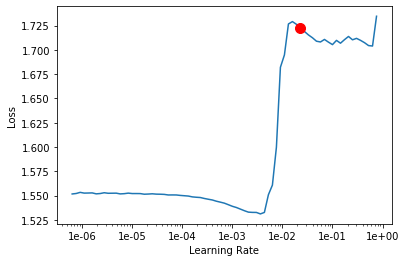

In [247]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [229]:
# Default to LR if lr_find() has not been run
try:
    lr = learner.recorder.min_grad_lr
except:
    lr = LR
lr

0.0003311311214825911

In [249]:
for iter in range(SAVE_MODEL_ITERATIONS):
    print(iter)
    learner.fit_one_cycle(EPOCHS_BEFORE_SAVING, max_lr=lr)
    valid, ctc  = learner.validate()
    learner.save(MODEL_NAME+f'-Valid[{valid}]-CTC[{ctc}]')

0


epoch,train_loss,valid_loss,ctc_error,time
0,1.554023,1.542756,82.142857,00:09
1,1.544157,1.554961,91.333333,00:09
2,1.531856,1.541755,78.500000,00:09


1


epoch,train_loss,valid_loss,ctc_error,time
0,1.511155,1.544416,77.888889,00:09
1,1.503020,1.552669,85.545455,00:10
2,1.491845,1.547943,79.333333,00:09


2


epoch,train_loss,valid_loss,ctc_error,time
0,1.472363,1.558629,74.714286,00:09
1,1.463174,1.556959,86.545455,00:09
2,1.451706,1.563110,82.380952,00:10


## Predict

In [258]:
x, y, _ = databunch.valid_dl.tensors
x_device = x[:BS].to(device=DEVICE)
learner.to_fp32()
y_pred = model(x_device).detach().cpu().numpy()

In [116]:
#gc.collect()
#torch.cuda.empty_cache()

In [232]:
!nvidia-smi

Tue Mar 31 12:25:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.116.00   Driver Version: 418.116.00   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:BC:00.0 Off |                    0 |
| N/A   43C    P0    74W / 350W |  22790MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [259]:
r = range(100, 101) #Range can't contain values larger than PRED_OUT_DIM

for index in [0, BS-1]:
    actual = pop.convert_idx_to_base_sequence(y[index], ALPHABET_VAL)
    prediction = y_pred[index]
    for pred, beam, accuracy in g.get_stats(prediction, actual, ALPHABET_STR, r):
        print(pred, beam, accuracy)
    print('')

CCCAATAATTCCGGACAACGCTTGCCACCTACG
AGTACGATACTATCATCA 100 100.0

CATCTTCTTCAGAAGATGCGGAATAACGTG
ACCTCTCTCTCAGGCGA 100 70.58823529411765



In [ ]:
g.get_stats(prediction, actual, ALPHABET_STR, r):

In [90]:
# Run assemble only if data is not fetched from featherfile
# TODO: Assembled should not be on a batch, but instead on a complete signal
if STRIDE != WINDOW_SIZE:
    decoded = pop.decode(y_pred, ALPHABET_STR, beam_size=15)
    assembled = pop.assemble(decoded, WINDOW_SIZE, STRIDE, ALPHABET)
    print('Assembled:', assembled)

## Further Training!

In [243]:
flatm = flatten_model(learner.model)

In [244]:
g1 = flatm[0:40]
g2 = flatm[40:100]
g3 = flatm[100:]

In [245]:
learner.split([g1,g2,g3]);

In [246]:
learner.freeze()

In [262]:
learner.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               [256, 100]           8,448      False     
______________________________________________________________________
BatchNorm1d          [256, 100]           512        True      
______________________________________________________________________
ReLU                 [1024, 100]          0          False     
______________________________________________________________________
Dropout              [256, 100]           0          False     
______________________________________________________________________
Conv1d               [256, 100]           8,448      False     
______________________________________________________________________
Conv1d               [256, 100]           65,536     False     
______________________________________________________________________
BatchNorm1d          [256, 100]           512        True      
________________________________________________________